<a href="https://colab.research.google.com/github/fpseverino/progetto-ml-ai/blob/main/Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [221]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

# Input del dataset
L'obiettivo di questo notebook è di ripulire i dataset dei vari Task da valori nulli, dagli "outlier" e di sostituire i valori non numerici con valori numerici.

Il risultato finale sarà un nuovo file `.csv` con le modifiche effettuate sul Task originale.

La variabile `num_task` può essere modificata per effettuare il processo di pulizia su un Task diverso.

In [222]:
num_task = 21
df = pd.read_csv("Task_{}.csv".format(num_task))
df.shape

(145, 134)

# Pulizia del dataset
Il `DataFrame` ottenuto dalla lettura del file `.csv` passa attraverso diverse operazioni di pulizia.

## Rimozione righe con `Label` uguale a -1
I sample identificati dalla `Label` pari a -1 possono essere rimossi, in quanto presentano tutte le feature uguali a 0.

In [223]:
num_sample = df.shape[0] # Numero totale dei sample prima della rimozione

# Rimuove righe con label uguale a -1
df = df[df["Label"] != -1]
print("Sample eliminati:", num_sample - df.shape[0])

Sample eliminati: 26


## Verifiche iniziali
Si controlla che non ci siano valori `NaN`, nulli o righe duplicate e vengono elencati i tipi di dato di tutte le feature.

In [224]:
# Controlla se ci sono righe duplicate
sample_duplicati = df.duplicated().sum()
if sample_duplicati > 0:
  print("Sample duplicati:", sample_duplicati)

In [225]:
# Controlla se ci sono valori null
valori_null = df.isnull().sum().sum()
if valori_null > 0:
  print("Valori null:", valori_null)

In [226]:
# Controlla se ci sono valori NaN
valori_nan = df.isna().sum().sum()
if valori_nan > 0:
  print("Valori NaN:", valori_nan)

In [227]:
# Controlla tipi di dato delle colonne
print(df.dtypes)
print("-------------------------------------------")
df.dtypes.value_counts(dropna = False)

Id                                    int64
mean:velocity:axis-x(in-air)        float64
std:velocity:axis-x(in-air)         float64
iqr:velocity:axis-x(in-air)         float64
mean:velocity:axis-x(on-surface)    float64
                                     ...   
Gender                               object
Age                                 float64
Dominant_Hand                        object
Label                                 int64
Task                                  int64
Length: 134, dtype: object
-------------------------------------------


float64    129
int64        3
object       2
Name: count, dtype: int64

## Selezione delle feature numeriche
Serve isolare le colonne che contengono valori numerici per potervi applicare operazioni di pulizia.

### Valutazione sulla feature `Age`
La colonna `Age` contiene valori numerici, ma non contiene né valori pari a 0 né "outlier", quindi non necessita di pulizia e può tranquillamente essere esclusa dalle colonne numeriche.

In [228]:
# La feature Age non ha né valori pari a 0 né "outlier"
df["Age"].value_counts(dropna = False)

Age
6.0    91
7.0    24
9.0     3
8.0     1
Name: count, dtype: int64

### Selezione delle colonne numeriche
Vengono selezionate tutte le colonne che hanno tipi di dato numerici, escludendo `Label`, `Age`, `Id` e `Task` che non necessitano di pulizia, e vengono salvate nella variabile `colonne_numeriche`.

In [229]:
# Seleziona le feature numeriche (meno Label e Age)
colonne_numeriche = df.select_dtypes(include=[np.number]).columns
colonne_numeriche = colonne_numeriche.drop("Label")
colonne_numeriche = colonne_numeriche.drop("Age") # La feature Age non ha ne valori pari a 0 ne "outlier"
colonne_numeriche = colonne_numeriche.drop("Id")
colonne_numeriche = colonne_numeriche.drop("Task")

## Sostituzione dei valori numerici pari a 0

I valori numerici pari a 0 saranno sostituiti dal valore medio della feature per ogni specifica `Label`, calcolato escludendo gli stessi campi pari a 0.

In [230]:
# Per ogni feature numerica
for colonna in colonne_numeriche:
    # calcola la media per ogni Label, escludendo i valori 0
    valori_medi = df[df[colonna] != 0].groupby("Label")[colonna].mean()

    # Per ogni 'Label' nel DataFrame
    for label in df["Label"].unique():
        # se la Label esiste in valori_medi
        if label in valori_medi.index:
            # sostituisci i valori 0 con la media corrispondente per quella Label
            df.loc[(df["Label"] == label) & (df[colonna] == 0), colonna] = valori_medi[label]

## Rintracciamento e sostituzione dei valori "outlier"
Gli "outlier" sono valori anomali, ovvero che si distaccano eccessivamente dal valore medio della colonna.

### Valori minimi e massimi prima della sostituzione degli "outlier"
Per verificare se in una colonna sono presenti valori "outlier" si possono comparare i valori minimi e massimi della colonna con il suo valore medio, oppure si può ricorrere alla visualizzazione tramite `boxplot`.

In [231]:
df.describe()

,Id,mean:velocity:axis-x(in-air),std:velocity:axis-x(in-air),iqr:velocity:axis-x(in-air),mean:velocity:axis-x(on-surface),std:velocity:axis-x(on-surface),iqr:velocity:axis-x(on-surface),mean:velocity:axis-y(in-air),std:velocity:axis-y(in-air),iqr:velocity:axis-y(in-air),...,std:ratio_of_stroke_durations,iqr:ratio_of_stroke_durations,writing_duration(on-surface),writing_duration_overall,ratio_of_writing_durations,number_of_interruptions,number_of_interruptions_relative,Age,Label,Task
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,1.190000e+02,119.000000,119.000000,119.000000,...,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.0
mean,74.134454,1.092989,6.637259,2.178910,0.591317,0.913416,2.000000e+00,1.366033,8.214521,1.980917,...,11.137034,11.216164,40.102353,41.844538,48.090299,8.264706,0.169823,6.294118,1.890756,21.0
std,42.996437,0.902524,8.882468,0.402854,0.235574,0.140344,3.904450e-13,0.937642,8.527273,0.425609,...,7.512442,7.684848,12.893768,14.628517,108.135553,6.419258,0.100668,0.615519,0.407346,0.0
min,1.000000,0.161538,0.544961,2.000000,0.235552,0.644685,2.000000e+00,0.219178,0.624754,0.000000,...,0.010440,0.010440,14.415000,14.420000,3.880740,2.000000,0.033904,6.000000,0.000000,21.0
25%,35.500000,0.770749,3.144829,2.000000,0.437244,0.831900,2.000000e+00,1.032000,4.683982,2.000000,...,6.919434,6.126454,31.340000,31.410000,23.796485,4.000000,0.113533,6.000000,2.000000,21.0
50%,79.000000,1.112846,6.987453,2.193548,0.540244,0.897260,2.000000e+00,1.430516,8.678108,2.052083,...,11.710702,11.844956,39.115000,40.160000,36.806636,8.500000,0.173889,6.000000,2.000000,21.0
75%,111.500000,1.112846,6.987453,2.193548,0.662932,0.957372,2.000000e+00,1.430516,8.678108,2.052083,...,11.710702,11.844956,48.200000,50.247500,36.806636,8.500000,0.173889,6.000000,2.000000,21.0
max,145.000000,9.382353,77.355247,6.000000,1.585885,1.801404,2.000000e+00,9.970588,82.580318,4.000000,...,54.992345,58.778139,91.275000,115.030000,1105.375000,46.000000,0.586611,9.000000,2.000000,21.0


<Axes: >

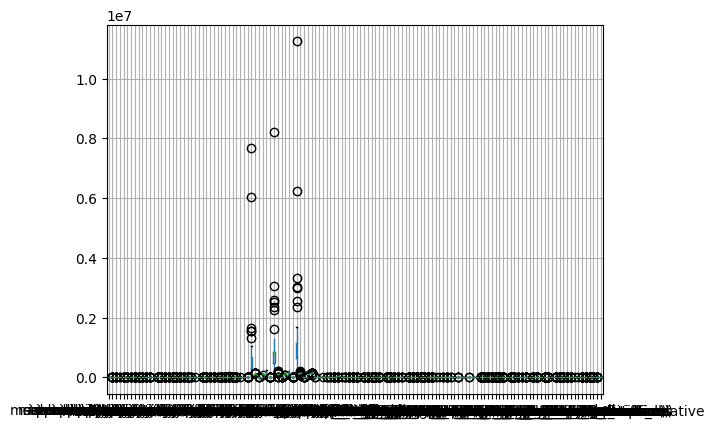

In [232]:
df.boxplot()

### Sostituzione degli "outlier"
I valori "outlier" saranno sostituiti dal valore medio della feature per ogni specifica `Label`, calcolato escludendo gli stessi "outlier".

In [233]:
# Per ogni feature numerica
for colonna in colonne_numeriche:
    # Calcola i percentili per ciascuna feature numerica
    q_low = df[colonna].quantile(0.01)
    q_high = df[colonna].quantile(0.99)

    # Calcola la media per ogni Label, escludendo gli outlier
    valori_medi = df[(df[colonna] > q_low) & (df[colonna] < q_high)].groupby("Label")[colonna].mean()

    # Definisci una funzione per sostituire i valori outlier con la media corrispondente
    def sostituisci_outlier(riga):
        label = riga["Label"]
        valore = riga[colonna]
        if label in valori_medi.index and (valore <= q_low or valore >= q_high):
            return valori_medi[label]
        else:
            return valore

    # Applica la funzione a tutte le righe
    df[colonna] = df.apply(sostituisci_outlier, axis=1)

### Valori minimi e massimi dopo la sostituizione degli "outlier"
Si può verificare il risultato dell'operazione di sostituzione degli "outlier" andando a confrontare i valori massimi e minimi e il `boxplot` prima e dopo l'operazione di sostituzione degli "outlier".

In [234]:
df.describe()

,Id,mean:velocity:axis-x(in-air),std:velocity:axis-x(in-air),iqr:velocity:axis-x(in-air),mean:velocity:axis-x(on-surface),std:velocity:axis-x(on-surface),iqr:velocity:axis-x(on-surface),mean:velocity:axis-y(in-air),std:velocity:axis-y(in-air),iqr:velocity:axis-y(in-air),...,std:ratio_of_stroke_durations,iqr:ratio_of_stroke_durations,writing_duration(on-surface),writing_duration_overall,ratio_of_writing_durations,number_of_interruptions,number_of_interruptions_relative,Age,Label,Task
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,1.190000e+02,119.000000,119.000000,119.000000,...,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.0
mean,74.134454,1.006148,5.660187,2.134609,0.580555,0.905694,2.000000e+00,1.294184,7.488960,1.956132,...,10.756234,10.762100,39.813479,41.390548,37.318650,9.102941,0.165887,6.294118,1.890756,21.0
std,42.996437,0.320089,3.073232,0.087780,0.195808,0.101088,3.327591e-13,0.453077,4.486163,0.370415,...,5.749379,5.516062,11.144085,12.113262,33.756903,4.072309,0.086356,0.615519,0.407346,0.0
min,1.000000,0.267123,0.680361,2.000000,0.313755,0.728887,2.000000e+00,0.363636,0.771389,0.000000,...,1.085589,1.085589,16.400000,16.405000,4.284649,4.000000,0.035862,6.000000,0.000000,21.0
25%,35.500000,0.819923,3.364900,2.000000,0.444695,0.833713,2.000000e+00,1.053872,4.928873,2.000000,...,7.419768,6.931653,31.955000,32.232500,25.280855,8.500000,0.116891,6.000000,2.000000,21.0
50%,79.000000,1.112846,6.987453,2.193548,0.549108,0.902133,2.000000e+00,1.430516,8.678108,2.052083,...,11.710702,11.844956,39.694764,40.805000,36.806636,8.500000,0.173889,6.000000,2.000000,21.0
75%,111.500000,1.112846,6.987453,2.193548,0.654142,0.954804,2.000000e+00,1.430516,8.678108,2.052083,...,11.710702,11.844956,47.997500,49.447500,36.806636,9.100000,0.173889,6.000000,2.000000,21.0
max,145.000000,2.169049,16.871146,2.193548,1.460284,1.245485,2.000000e+00,2.727554,26.186697,2.052083,...,34.960985,33.176471,70.720000,74.185000,314.345524,28.000000,0.451249,9.000000,2.000000,21.0


<Axes: >

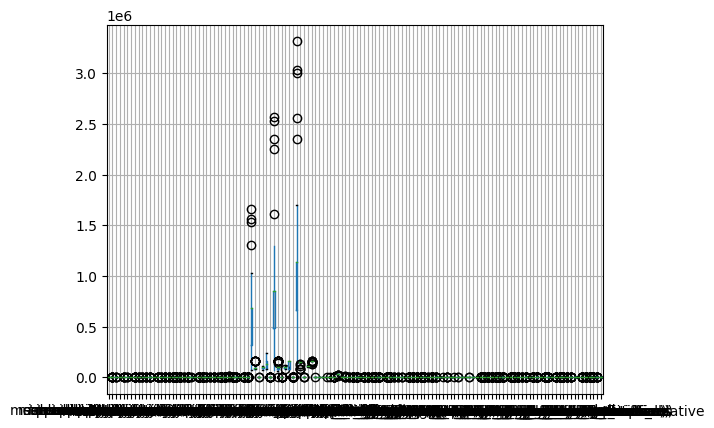

In [235]:
df.boxplot()

## Codifica dei valori non numerici
I valori non numerici, come le stringhe, che rappresentano un gruppo di costanti (p. e. "Vero" e "Falso") devono essere convertiti in valori numerici utilizzando la codifica "one-hot" o associando un numero diverso per ogni costante.

### Codifica della feature `Gender`
La colonna `Gender` contiene valori di tipo stringa uguali a "Femminile" o "Maschile".

La feature può essere codificata in valori numerici sostituendo la stringa "Femminile" con il numero `0` e la stringa "Maschile" con il numero `1`.

In [236]:
# Controllare valori della colonna Gender
print(df["Gender"].value_counts())

# Sostituire le stringhe con valori numerici
df["Gender"] = df.Gender.apply(lambda x: x.replace("Femminile", "0"))
df["Gender"] = df.Gender.apply(lambda x: x.replace("Maschile", "1"))

# Controllare se i valori della colonna Gender sono stati sostituiti correttamente
print("-------------------------")
print(df["Gender"].value_counts())

# I valori rimangono di tipo "object" (stringhe)
print("-------------------------")
print(df.dtypes.value_counts(dropna = False))

Gender
Femminile    64
Maschile     55
Name: count, dtype: int64
-------------------------
Gender
0    64
1    55
Name: count, dtype: int64
-------------------------
float64    129
int64        3
object       2
Name: count, dtype: int64


### Codifica della feature `Dominant_Hand`
La colonna `Dominant_Hand` contiene valori di tipo stringa uguali a "Destra" o "Sinistra".

La feature può essere codificata in valori numerici sostituendo la stringa "Destra" con il numero `0` e la stringa "Sinistra" con il numero `1`.

In [237]:
# Controllare valori della colonna Dominant_Hand
print(df["Dominant_Hand"].value_counts())

# Sostituire le stringhe con valori numerici
df["Dominant_Hand"] = df.Dominant_Hand.apply(lambda x: x.replace("Destra", "0"))
df["Dominant_Hand"] = df.Dominant_Hand.apply(lambda x: x.replace("Sinistra", "1"))

# Controllare se i valori della colonna Dominant_Hand sono stati sostituiti correttamente
print("-------------------------")
print(df["Dominant_Hand"].value_counts())

# I valori rimangono di tipo "object" (stringhe)
print("-------------------------")
print(df.dtypes.value_counts(dropna = False))

Dominant_Hand
Destra      106
Sinistra     13
Name: count, dtype: int64
-------------------------
Dominant_Hand
0    106
1     13
Name: count, dtype: int64
-------------------------
float64    129
int64        3
object       2
Name: count, dtype: int64


## Verifiche finali
Ricontrolla che non ci siano valori `NaN`, nulli o righe duplicate alla fine del processo di pulizia del `DataFrame`.

In [238]:
# Controlla se ci sono valori NaN
valori_nan = df.isna().sum().sum()
if valori_nan > 0:
  print("Valori NaN:", valori_nan)

In [239]:
# Controlla se ci sono valori null
valori_null = df.isnull().sum().sum()
if valori_null > 0:
  print("Valori null:", valori_null)

In [240]:
# Controlla se ci sono righe duplicate
sample_duplicati = df.duplicated().sum()
if sample_duplicati > 0:
  print("Sample duplicati:", sample_duplicati)

# Output del dataset pulito
Infine il dataset viene stampato a schermo e viene salvata sul disco una copia del file `.csv` iniziale a cui sono state applicate tutte le operazioni di pulizia.

In [241]:
df

,Id,mean:velocity:axis-x(in-air),std:velocity:axis-x(in-air),iqr:velocity:axis-x(in-air),mean:velocity:axis-x(on-surface),std:velocity:axis-x(on-surface),iqr:velocity:axis-x(on-surface),mean:velocity:axis-y(in-air),std:velocity:axis-y(in-air),iqr:velocity:axis-y(in-air),...,writing_duration(on-surface),writing_duration_overall,ratio_of_writing_durations,number_of_interruptions,number_of_interruptions_relative,Gender,Age,Dominant_Hand,Label,Task
0,1,1.112846,6.987453,2.193548,0.720029,0.960008,2.0,1.430516,8.678108,2.052083,...,27.735,27.740000,36.806636,8.50,0.173889,0,6.0,0,2,21
1,2,0.776398,4.148100,2.145622,0.435049,0.825124,2.0,1.322981,7.914216,2.000000,...,47.420,52.305000,9.817805,10.00,0.191186,1,6.0,0,2,21
2,3,1.112846,6.987453,2.193548,0.872712,1.118904,2.0,1.430516,8.678108,2.052083,...,24.315,24.320000,36.806636,8.50,0.173889,0,6.0,0,2,21
3,4,1.112846,6.987453,2.193548,1.048787,1.122415,2.0,1.430516,8.678108,2.052083,...,19.985,19.990000,36.806636,8.50,0.173889,1,6.0,1,2,21
4,5,0.723735,1.053778,2.000000,0.540244,0.925960,2.0,0.412451,0.809189,0.000000,...,40.130,40.135000,25.571984,4.00,0.117062,1,6.0,1,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,141,1.112846,6.987453,2.193548,0.521479,0.886544,2.0,1.430516,8.678108,2.052083,...,40.155,40.160000,36.806636,8.50,0.173889,0,6.0,0,2,21
141,142,1.246888,7.119697,2.000000,0.779946,1.001810,2.0,1.136929,6.124734,2.000000,...,26.130,31.025000,5.421162,14.00,0.451249,1,6.0,0,2,21
142,143,0.341772,1.035889,2.000000,0.722230,1.218330,2.0,0.443038,2.007876,2.000000,...,35.335,36.140000,44.727848,13.25,0.055340,1,6.0,0,1,21
143,144,1.112846,6.987453,2.193548,0.933735,1.044162,2.0,1.430516,8.678108,2.052083,...,23.240,23.315000,34.142643,9.10,0.085782,1,7.0,0,2,21


In [242]:
df.to_csv("Task_{}_clean.csv".format(num_task), index=False)